## Run bayesian inference

the notebook start by first loading the model config and checking the data, 

then you can run the sampling either in the HPC or in the notebook

In [1]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import numpy as np
import pandas as pd
from pl_temp_fit import (
    Exp_data_utils,
    config_utils,
    covariance_utils,
    generate_data_utils,
)

# access the right directory
os.chdir("/media/mohammed/Work/pl_temp_fit")
#os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
# get test_ids in the database
path_database = Path("fit_experimental_emcee_pl/fit_data_base/")
model_config_files = list(path_database.glob("*.json"))
test_id_list = []
list_model_config = []
for id,model_config_file in enumerate(model_config_files):
    #print(id,model_config_file)
    test_id = model_config_file.name.replace(".json","")
    test_id_list.append(test_id)
    model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = path_database)
    #print(model_config_save["csv_name_pl"].split("/")[-1])
    list_model_config.append(model_config_save)

if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all["csv_name_pl"] = df_all["csv_name_pl"].apply(lambda x: x.split("/")[-1])
df_all[["csv_name_pl","params_to_fit_init","min_bounds","max_bounds"]].head(10)

,csv_name_pl,params_to_fit_init,min_bounds,max_bounds
24,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
21,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
1,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.2, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.6, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
0,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."
16,Y6DIB-300K_G0_750.0nm_1550.0nm_22-06-2024-13h-...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."
26,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."
25,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
22,Y6DIB-300K_G0_750.0nm_1550.0nm_22-06-2024-13h-...,"{'EX': {'E': 1.3, 'sigma': 0.01, 'Li': 0.078, ...","{'EX': {'E': 1.2, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.6, 'sigma': 0.05, 'Li': 0.2, 'L..."
7,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
9,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."


In [3]:
search_for = "Y6"
df_all[df_all["csv_name_pl"].str.contains(search_for)][["csv_name_pl","params_to_fit_init","min_bounds","max_bounds"]]



,csv_name_pl,params_to_fit_init,min_bounds,max_bounds
24,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
21,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
1,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.2, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.6, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
0,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."
16,Y6DIB-300K_G0_750.0nm_1550.0nm_22-06-2024-13h-...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."
26,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."
25,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
22,Y6DIB-300K_G0_750.0nm_1550.0nm_22-06-2024-13h-...,"{'EX': {'E': 1.3, 'sigma': 0.01, 'Li': 0.078, ...","{'EX': {'E': 1.2, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.6, 'sigma': 0.05, 'Li': 0.2, 'L..."
7,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.04, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.2, 'Lo..."
9,Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024...,"{'EX': {'E': 1.37, 'sigma': 0.01, 'Li': 0.078,...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.03, ...","{'EX': {'E': 1.5, 'sigma': 0.03, 'Li': 0.2, 'L..."


In [4]:
import importlib
# load and update the model config
importlib.reload(config_utils)
test_id = test_id_list[1]
model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = path_database)
csv_name = model_config_save["csv_name_pl"]
print(model_config_save["csv_name_pl"].split("/")[-1])
# add the new experimental data
model_config_save["params_to_fit_init"] = {
    "EX": {"E": 1.37, "sigma": 0.01, "Li": 7.8e-2, "Lo": 0.11, "hO": 0.159, "disorder_ext": 0.05},
    "CT": {},
    "D": {},
}
model_config_save["min_bounds"] = {
    "EX": {"E": 1.2, "sigma": 0.001, "Li": 0.03, "Lo": 0.03, "hO": 0.1, "disorder_ext": 0.01},
    "CT": {},
    "D": {},
}
model_config_save["max_bounds"] = {
    "EX": {"E": 1.6, "sigma": 0.1, "Li": 0.2, "Lo": 0.2, "hO": 0.2, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
model_config_save["save_folder"] = "/media/mohammed/Work/pl_temp_fit/fit_experimental_emcee_pl/fit_data/Y6DIB-1mat-300K_G0_700/86ee9cec-3710-4392-9d7c-79d243f1b208"

model_config_save["csv_name_pl"] = "/media/mohammed/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s_mod_split0_split500.csv"
model_config_save["max_abs_pos_exp"] = 1.45
model_config_save["error_in_max_abs_pos"] = 0.01 # in eV
model_config_save["lifetime_exp_high_temp"] = 1e-9 # in seconds
model_config_save["error_in_lifetime_high_temp"]= 1e-10 # in seconds
config_utils.updata_model_config(test_id,path_database, model_config_save)

Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s_mod_split0_split500.csv


'86ee9cec-3710-4392-9d7c-79d243f1b208'

shape of mean value plot is (61, 7)


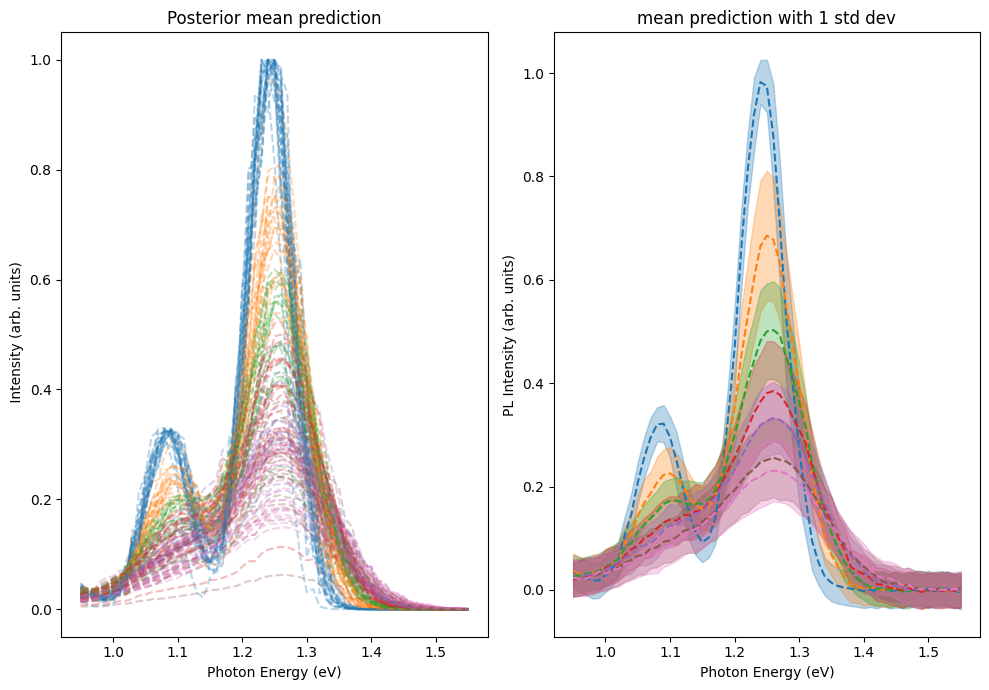

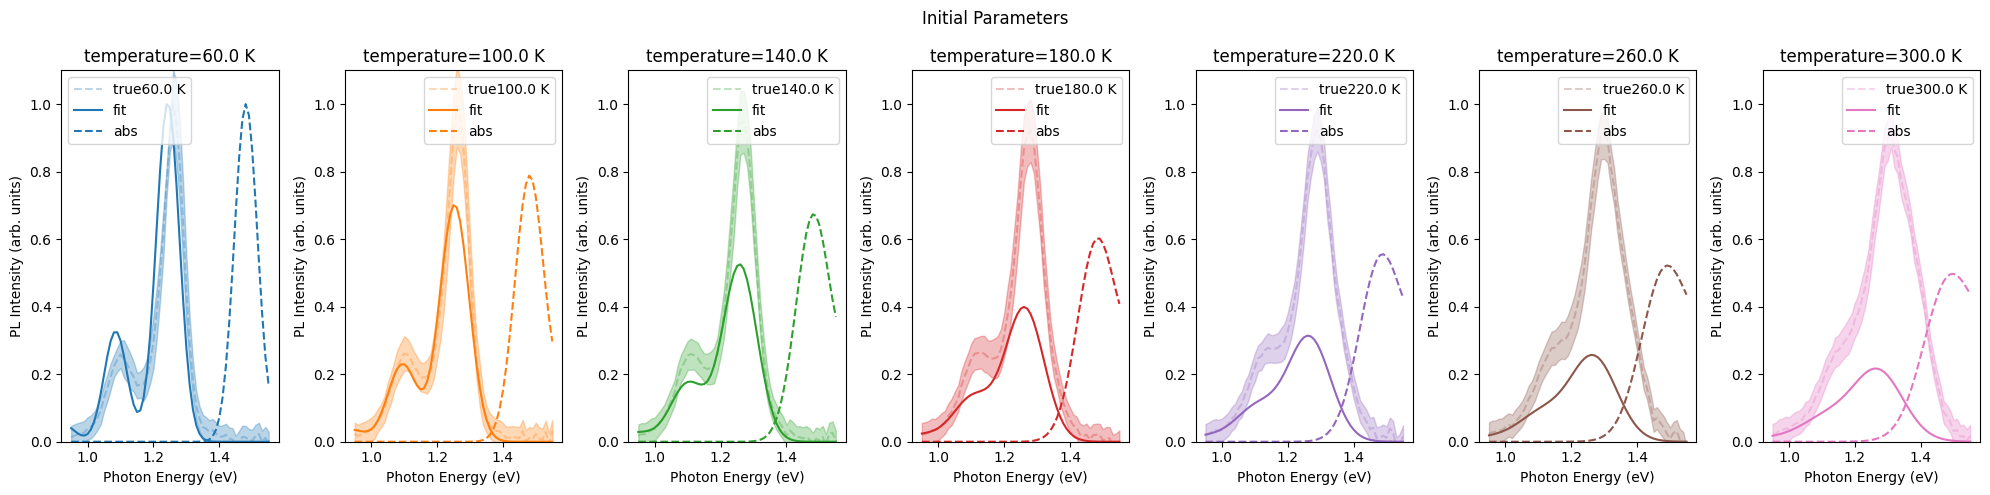

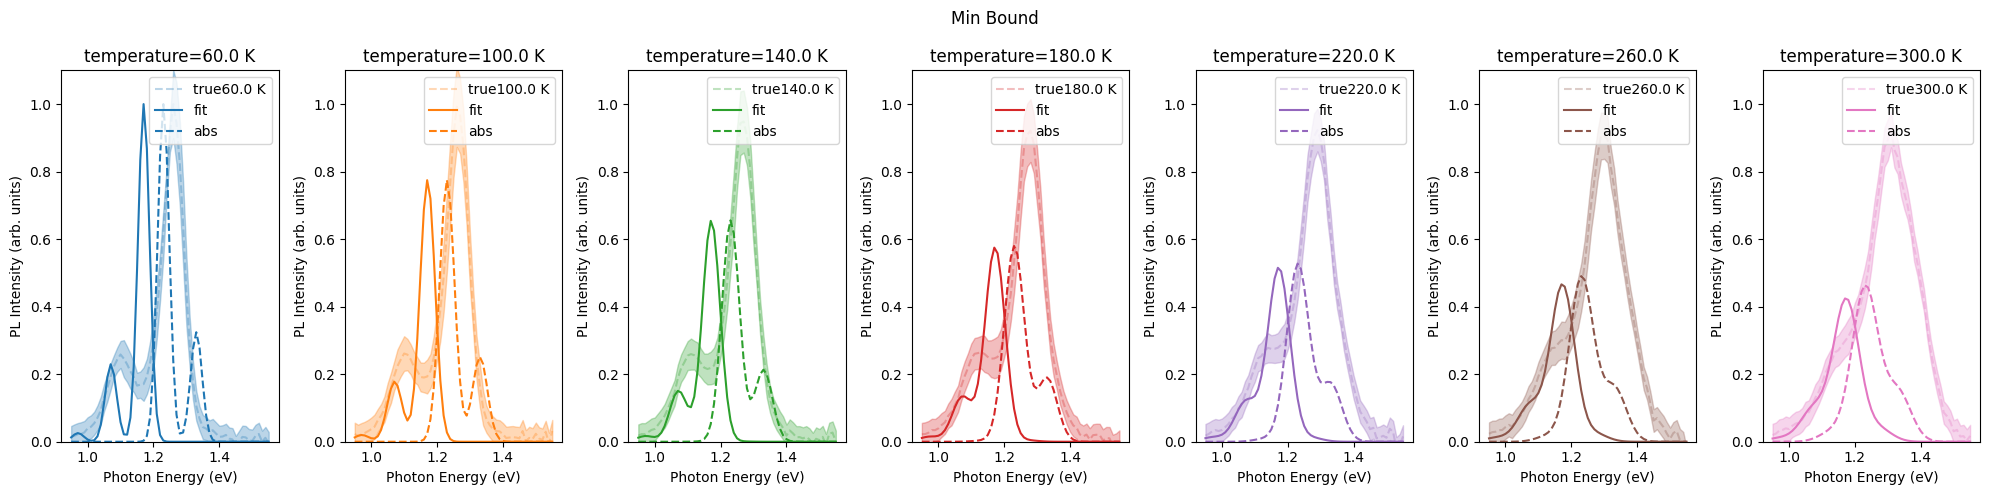

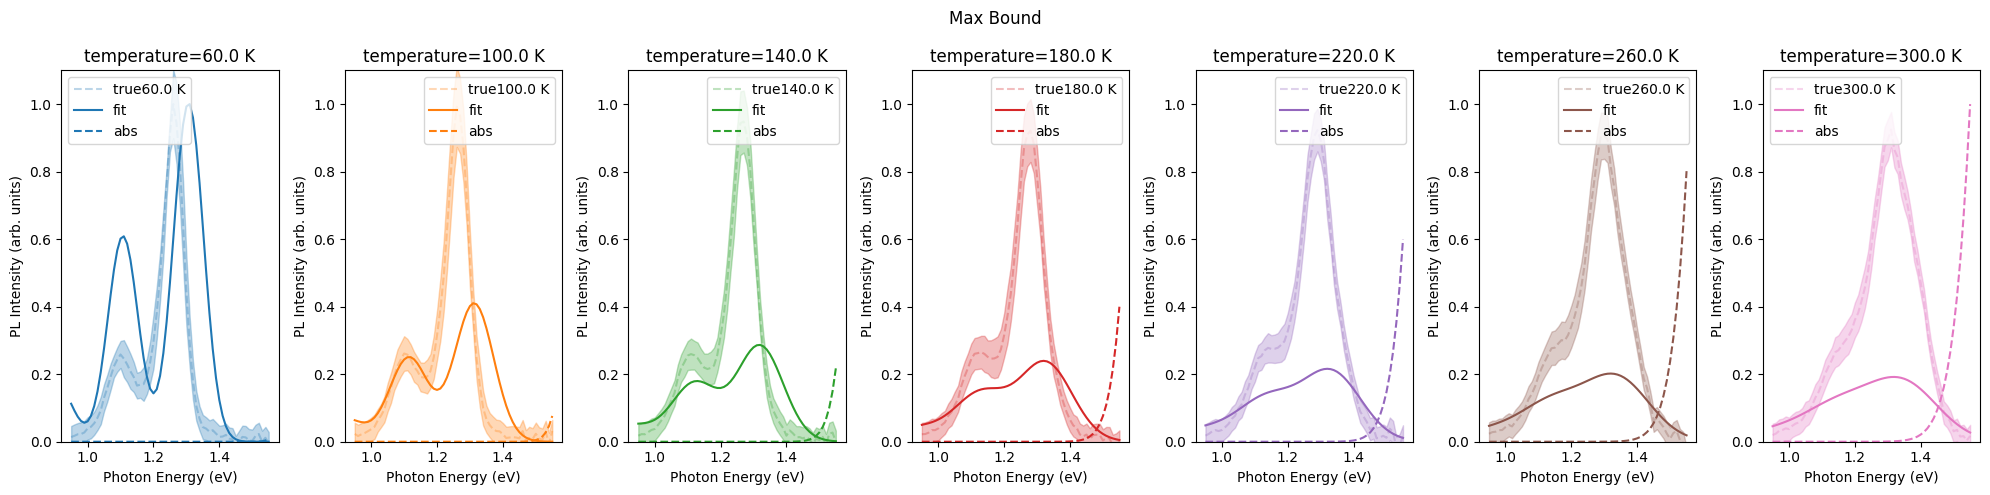

In [5]:
# plot the results with initial parameters
# and the maximum and minumum bounds
import importlib

from pl_temp_fit import fit_pl_utils

importlib.reload(fit_pl_utils)

fit_pl_utils.plot_fit_limits(model_config,model_config_save)


### run sampler in the notebook

In [6]:
import emcee

filename = model_config_save["save_folder"] + "/sampler.h5"
if os.path.exists(filename):
    try:
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        distribution = reader.get_chain(discard=0, flat=True)  
        true_parameters = fit_pl_utils.get_param_dict(model_config_save["params_to_fit_init"],distribution[-1])
    except AttributeError:
        print("no sampler found")
        true_parameters = model_config_save["params_to_fit_init"]
else:
    true_parameters = model_config_save["params_to_fit_init"]
    print("no sampler found")

In [7]:
from pl_temp_fit.data_generators import PLAbsAndLifetime

importlib.reload(PLAbsAndLifetime)
save_folder = model_config_save["save_folder"]
csv_name = model_config_save["csv_name_pl"]

Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

pl_data_gen = PLAbsAndLifetime.PLAbsAndLifetime(temperature_list,hws)
pl_data_gen.error_in_lifetime_high_temp = model_config_save["error_in_lifetime_high_temp"]
pl_data_gen.error_in_max_abs_pos = model_config_save["error_in_max_abs_pos"]
pl_data_gen.max_abs_pos_exp = model_config_save["max_abs_pos_exp"]
pl_data_gen.lifetime_exp_high_temp = model_config_save["lifetime_exp_high_temp"]

pl_data_gen.update_with_model_config(model_config_save)
co_var_mat_pl, variance_pl = pl_data_gen.get_covariance_matrix()


In [8]:
#test log likelihood
from pl_temp_fit import Emcee_utils, fit_pl_utils, FitUtils

save_folder = model_config_save["save_folder"]

inv_cov_pl = np.linalg.inv(co_var_mat_pl)
coords, _ = FitUtils.get_initial_coords(
        pl_data_gen,
        coeff_spread=0.1,
        num_coords=1,
        save_folder=save_folder,
        restart_sampling=False,  
    )
log_like, chi_squared, data = pl_data_gen.log_likelihood(
            coords[0],
            Exp_data,
            inv_cov_pl,
        )
data.D.hw[data.D.alpha[:, -1].argmax()]  

np.float64(1.5)

In [9]:
from pl_temp_fit import Emcee_utils, fit_pl_utils, FitUtils
importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(FitUtils)
importlib.reload(fit_pl_utils)

save_folder = model_config_save["save_folder"]

fit_pl_utils.run_sampler_parallel(
    save_folder,
    Exp_data,
    co_var_mat_pl,
    pl_data_gen,
    nsteps=5,
    coeff_spread=0.1,
    num_coords = 32,
    restart_sampling=False,
    num_processes=30,
)

100%|██████████| 5/5 [00:11<00:00,  2.31s/it]

multi process took 14.3 seconds


In [10]:
from pl_temp_fit import Emcee_utils, fit_pl_utils

importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_pl_utils)
importlib.reload(Emcee_utils)

filename = model_config_save["save_folder"] + "/sampler_single.h5"
if os.path.exists(filename):
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    distribution = reader.get_chain(discard=0, flat=True)  
    true_parameters = fit_pl_utils.get_param_dict(model_config_save["params_to_fit_init"],distribution[-1])
else:
    true_parameters = model_config_save["params_to_fit_init"]
    print("no sampler found")
save_folder = model_config_save["save_folder"] + "/single_core"
os.makedirs(save_folder, exist_ok=True)
fit_pl_utils.run_sampler_single(
    save_folder,
    Exp_data,
    co_var_mat_pl,
    pl_data_gen,
    nsteps=5,
    coeff_spread=0.1,
    num_coords = 32,
    restart_sampling=False,
)

no sampler found


100%|██████████| 5/5 [00:49<00:00,  9.92s/it]

single process took 58.9 seconds


In [ ]:
soln_min = pl_data_gen.get_maximum_likelihood_estimate(
        Exp_data,
        co_var_mat_pl,
        save_folder,
        coeff_spread=0.1,
        num_coords=5,
    )

### run sampling in the HPC


In [6]:
model_config_id = test_id
csv_name = model_config_save["csv_name_pl"]
results_name = csv_name.replace(".csv","").split("/")[-1]
sh_name = f"Run_EMCEE_{results_name}.sh"
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=80gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pl_temp_fit     \n"+\
    f"python src/pl_temp_fit/scripts/new_pl_sampling.py --model_config_id {model_config_id} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
print(script) 
path_to_script = f'HPC_bash_script'
Path(path_to_script).mkdir(parents=True, exist_ok=True)

with Path(path_to_script,f'{sh_name}').open('wb') as f:
    f.write( bytes(script, 'utf-8'))  
script= f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"#submit to HPC
#os.system(script)

#!/bin/bash 
#PBS -l walltime=07:59:01 
#PBS -l select=1:ncpus=32:mem=80gb:avx=true 
 
cd /rds/general/user/ma11115/home/pl_temp_fit/ 
module load anaconda3/personal 
source activate pl_temp_fit     
python src/pl_temp_fit/scripts/new_pl_sampling.py --model_config_id 86ee9cec-3710-4392-9d7c-79d243f1b208 



to run the scipt using the hpc you can just submit the job above

if you want ot run the job on the terminal you can run the script from the folder of pl_temp_fit using  for example

        python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id e7ed53f3-f1ef-46c2-9b98-35b366e9f04d 

where e7ed53f3-f1ef-46c2-9b98-35b366e9f04d  correspond to your model config id